In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import helpers.processing_helpers as ph

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

In [2]:
df_dev = pd.read_csv("./dataset/development.csv")

In [3]:
noise_indexes = [0,7,12,15,16,17]
acc_idxs = [1,2,3,4,5,6,8,9,10,11,13,14]
features = ["pmax", "negpmax", 'area', 'tmax', 'rms']

sensors_removed = df_dev.drop(columns=ph.get_column_names(features, noise_indexes))

# Starting with negpmax outliers

In [4]:
# Checking how many of the sensors have values above 0
negpmax_clms = sensors_removed[[f'negpmax[{i}]' for i in acc_idxs]]
df_above_zero = negpmax_clms[(negpmax_clms > 0).any(axis=1)]
#sensors_removed = sensors_removed.drop(df_above_zero.index.values)
df_above_zero

,negpmax[1],negpmax[2],negpmax[3],negpmax[4],negpmax[5],negpmax[6],negpmax[8],negpmax[9],negpmax[10],negpmax[11],negpmax[13],negpmax[14]
93055,-5.230824,74820.439676,-6.426794,-7.850610,-72.066412,-19.270636,-12.398489,-4.941119,-7.263858,-4.484512,-7.634818,-6.796109
188194,-5.892503,74827.377234,-5.836270,-5.698038,-19.653781,-5.550021,-4.592166,-4.340689,-40.689526,-10.598145,-39.415897,-4.135703
232393,-18.781116,-19.235596,-17.818414,-19.567654,-17.616177,-19.700745,-16.931372,-22.695142,-32.393964,-36.985382,-28.748840,74812.277374


In [5]:
# we are just going to set this value to -5, which we will see is this some kind of magic value that all non-close sensor will average to
# this is just for computing the average, but we will fix these values later for actual training
# row 232393 has the problem that it both has a column above 70k and also all the other columns are below -10
sensors_removed[negpmax_clms > 0] = -5

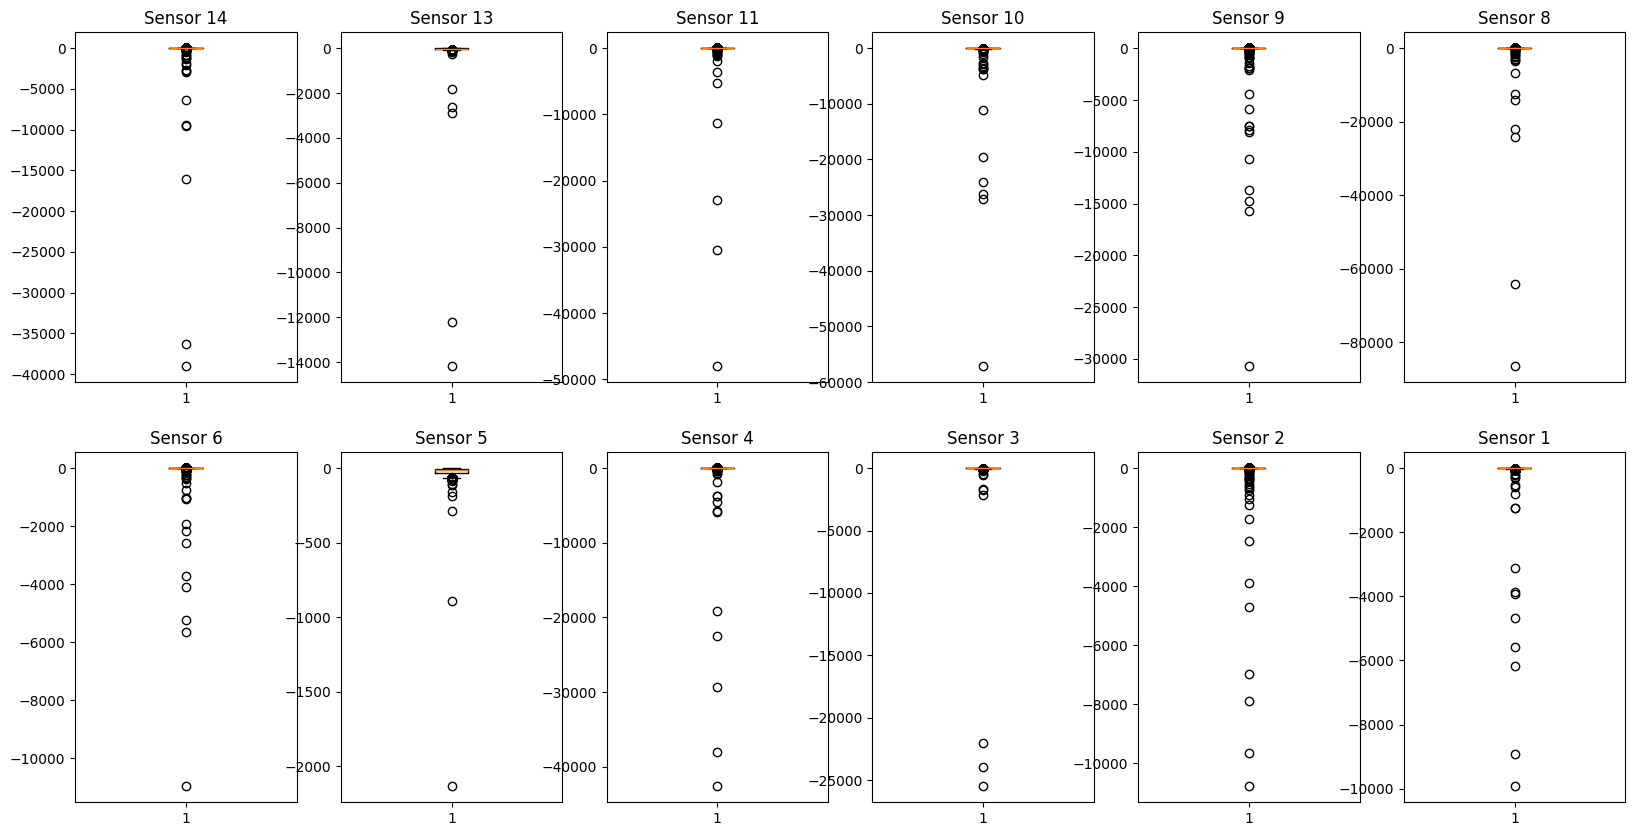

In [6]:
fig, ax = plt.subplots(2, 6, figsize=(20, 10))
idxs = acc_idxs.copy()
for i in range(2):
    for j in range(6):
        idx = idxs.pop()
        ax[i, j].boxplot(sensors_removed[f'negpmax[{idx}]'])
        ax[i, j].set_title("Sensor " + str(idx))

In [7]:
THRESH = -90

# removing those with less than -90 because they will impact average
negpmax_clm_names = ph.get_column_names(['negpmax'], acc_idxs)

negpmax = sensors_removed[negpmax_clm_names]

negpmax_below_thresh = negpmax[(negpmax < THRESH).any(axis=1)]
indexes = negpmax_below_thresh.index.values
below_thresh_removed = sensors_removed.drop(indexes)

In [8]:

negpmax_xy_clm_names = ph.get_column_names(['negpmax'], acc_idxs) + ['x', 'y']

negpmax_below_thresh_removed = below_thresh_removed[negpmax_xy_clm_names]

xy_negpmax_average = negpmax_below_thresh_removed.groupby(by=['x', 'y']).mean().reset_index()

In [9]:
negpmax_xy = sensors_removed[negpmax_xy_clm_names]

In [10]:
negpmax_xy_below_thresh = negpmax_xy.loc[negpmax_below_thresh.index.values]

clm_xy_index = dict()

for clm in negpmax_clm_names:
    series = negpmax_xy_below_thresh[clm]
    below = series[series < THRESH]
    indexes = below.index.values
    xy = negpmax_xy_below_thresh.loc[indexes][['x', 'y']]
    if not xy.empty:
        clm_xy_index[clm] = xy

In [11]:
updated = df_dev.drop(columns=ph.get_column_names(features, noise_indexes))
for clm, df in clm_xy_index.items():
    indexes = df.index.values
    for index in indexes:
        x = df.loc[index]['x']
        y = df.loc[index]['y']
        avg_value = xy_negpmax_average[(xy_negpmax_average['x'] == x) & (xy_negpmax_average['y'] == y)][clm].values[0]
        updated[clm].loc[index] = avg_value
        

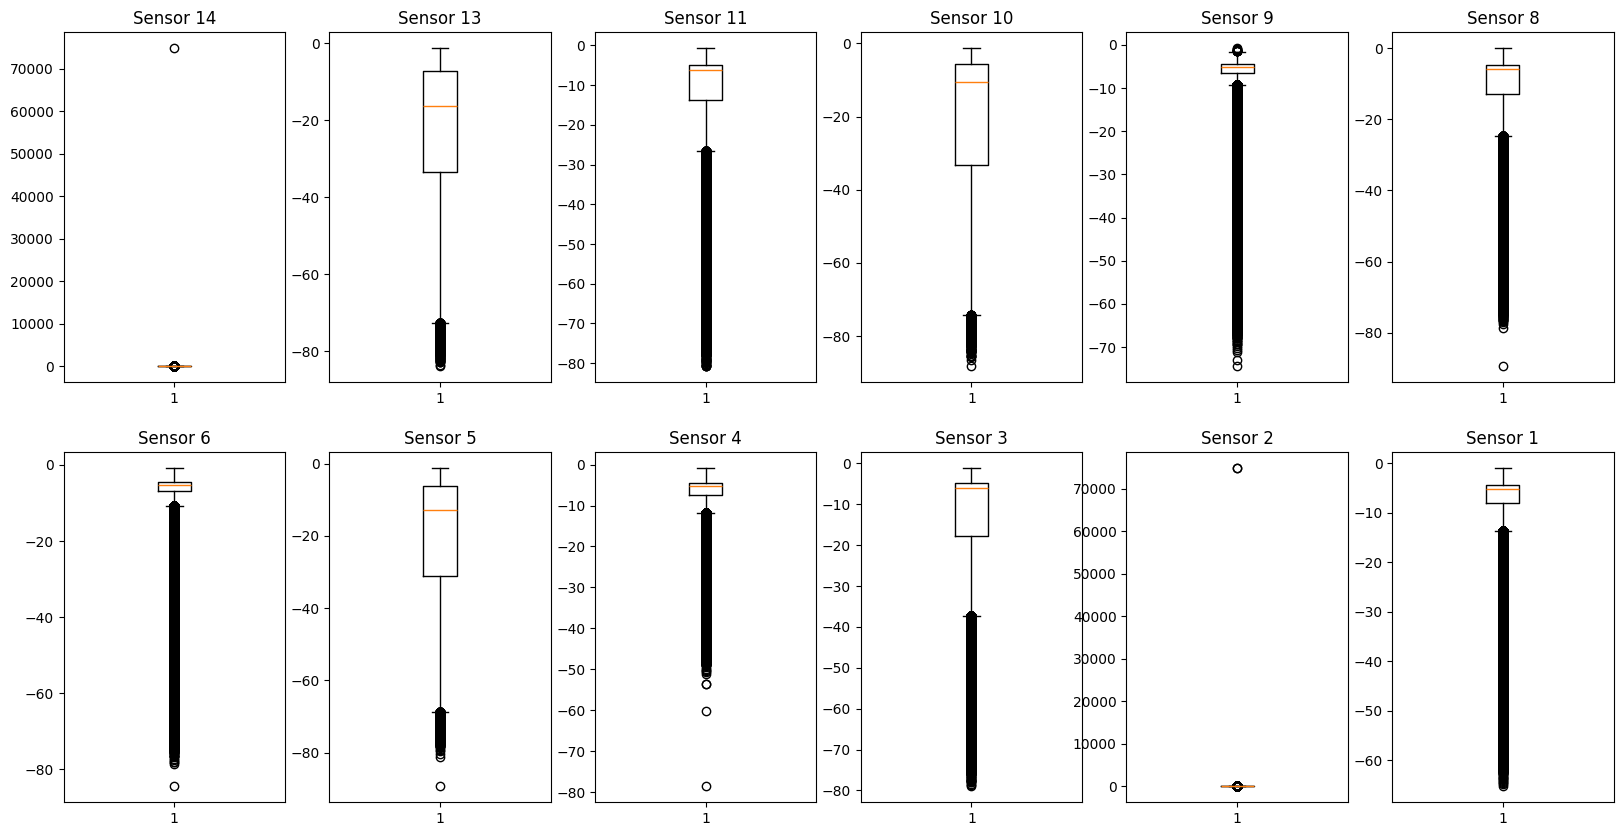

In [12]:
fig, ax = plt.subplots(2, 6, figsize=(20, 10))
idxs = acc_idxs.copy()
for i in range(2):
    for j in range(6):
        idx = idxs.pop()
        ax[i, j].boxplot(updated[f'negpmax[{idx}]'])
        ax[i, j].set_title("Sensor " + str(idx))

C:\Users\Arist\AppData\Local\Temp\ipykernel_11184\1850814838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negpmax[negpmax_clms > 0] = -15 # we need to do this to get the row 232393 in this part of the analysis
C:\Users\Arist\AppData\Local\Temp\ipykernel_11184\1850814838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negpmax[negpmax_clms > 0] = -15 # we need to do this to get the row 232393 in this part of the analysis


<Axes: xlabel='None', ylabel='None'>

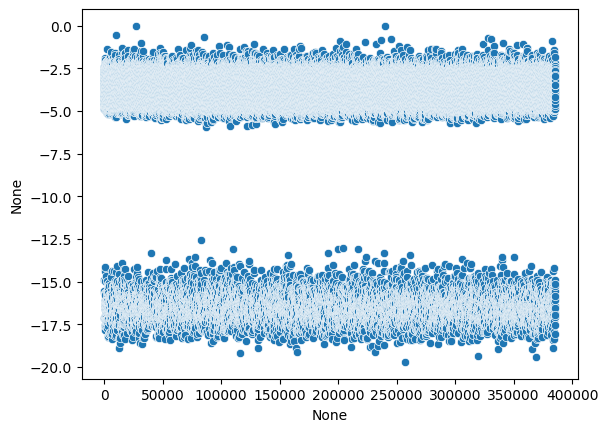

In [13]:
negpmax[negpmax_clms > 0] = -15 # we need to do this to get the row 232393 in this part of the analysis
max_values = negpmax.max(axis=1)
sb.scatterplot(x=max_values.index, y=max_values)

In [14]:
# When we plot these, its quite clear that these are in the minority and need to set back to the average

max_below_minus_ten = max_values[max_values < -10]
max_below_minus_ten

0        -15.625539
122      -14.926660
146      -14.879971
202      -15.557925
220      -17.126544
            ...    
385423   -15.527471
385436   -15.277594
385460   -17.551843
385476   -15.811865
385499   -15.145020
Length: 8063, dtype: float64

In [19]:
sensors_removed.loc[max_below_minus_ten.index.values][ph.PMAX_CLM_NAMES].min(axis=1).sort_values()

284806     1.854810
374439     2.255334
271561     2.294635
295215     2.295825
62358      2.296594
            ...    
204674    10.965448
199612    11.179517
221161    11.377481
213819    11.495273
98688     12.027478
Length: 8063, dtype: float64

In [21]:
sensors_removed.loc[98688][ph.NEGPMAX_CLM_NAMES + ph.PMAX_XY_CLM_NAMES]

negpmax[1]     -19.196194
negpmax[2]     -21.494192
negpmax[3]     -18.307513
negpmax[4]     -18.297071
negpmax[5]     -57.250812
negpmax[6]     -17.441641
negpmax[8]     -19.155951
negpmax[9]     -17.301071
negpmax[10]    -19.587189
negpmax[11]    -18.042871
negpmax[13]    -21.148349
negpmax[14]    -16.940315
pmax[1]         16.415195
pmax[2]         12.027478
pmax[3]         20.199959
pmax[4]         24.999799
pmax[5]        112.848218
pmax[6]         30.924570
pmax[8]         29.205898
pmax[9]         18.111893
pmax[10]        17.956900
pmax[11]        15.799597
pmax[13]        15.804468
pmax[14]        12.927264
x              285.000000
y              500.000000
Name: 98688, dtype: float64

In [16]:
# Now we need to get the x,y coordinates of all these rows, so we can reset these rows to the average
xy_below_minusten = sensors_removed.loc[max_below_minus_ten.index.values][['x', 'y']]
xy_below_minusten

,x,y
0,200.0,200.0
122,200.0,220.0
146,200.0,220.0
202,200.0,225.0
220,200.0,225.0
...,...,...
385423,600.0,595.0
385436,600.0,595.0
385460,600.0,595.0
385476,600.0,595.0


In [17]:
averages = xy_below_minusten.reset_index().merge(xy_negpmax_average, how='left').set_index('index')
display(xy_negpmax_average[(xy_negpmax_average['x'] == 200) & (xy_negpmax_average['y'] == 200)])
averages

,x,y,negpmax[1],negpmax[2],negpmax[3],negpmax[4],negpmax[5],negpmax[6],negpmax[8],negpmax[9],negpmax[10],negpmax[11],negpmax[13],negpmax[14]
0,200.0,200.0,-4.845706,-4.801516,-4.654121,-5.005079,-5.171986,-4.777304,-11.739298,-64.051939,-21.488339,-5.278961,-5.254068,-5.246676


,x,y,negpmax[1],negpmax[2],negpmax[3],negpmax[4],negpmax[5],negpmax[6],negpmax[8],negpmax[9],negpmax[10],negpmax[11],negpmax[13],negpmax[14]
index,,,,,,,,,,,,,,
0,200.0,200.0,-4.845706,-4.801516,-4.654121,-5.005079,-5.171986,-4.777304,-11.739298,-64.051939,-21.488339,-5.278961,-5.254068,-5.246676
122,200.0,220.0,-5.038313,-4.972181,-4.900001,-4.877863,-5.302632,-5.170944,-14.958118,-52.890482,-23.297207,-5.199857,-5.145041,-5.401888
146,200.0,220.0,-5.038313,-4.972181,-4.900001,-4.877863,-5.302632,-5.170944,-14.958118,-52.890482,-23.297207,-5.199857,-5.145041,-5.401888
202,200.0,225.0,-5.075175,-5.247518,-5.027784,-5.144445,-5.477116,-5.312682,-17.763278,-58.423932,-27.576618,-5.547585,-5.482663,-5.565423
220,200.0,225.0,-5.075175,-5.247518,-5.027784,-5.144445,-5.477116,-5.312682,-17.763278,-58.423932,-27.576618,-5.547585,-5.482663,-5.565423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385423,600.0,595.0,-28.548937,-34.761614,-37.897248,-5.829124,-6.066834,-5.520248,-5.612593,-5.563044,-5.943101,-5.735031,-8.510827,-5.998453
385436,600.0,595.0,-28.548937,-34.761614,-37.897248,-5.829124,-6.066834,-5.520248,-5.612593,-5.563044,-5.943101,-5.735031,-8.510827,-5.998453
385460,600.0,595.0,-28.548937,-34.761614,-37.897248,-5.829124,-6.066834,-5.520248,-5.612593,-5.563044,-5.943101,-5.735031,-8.510827,-5.998453


In [18]:
averages = averages.drop(columns=['x', 'y'])
averages

,negpmax[1],negpmax[2],negpmax[3],negpmax[4],negpmax[5],negpmax[6],negpmax[8],negpmax[9],negpmax[10],negpmax[11],negpmax[13],negpmax[14]
index,,,,,,,,,,,,
0,-4.845706,-4.801516,-4.654121,-5.005079,-5.171986,-4.777304,-11.739298,-64.051939,-21.488339,-5.278961,-5.254068,-5.246676
122,-5.038313,-4.972181,-4.900001,-4.877863,-5.302632,-5.170944,-14.958118,-52.890482,-23.297207,-5.199857,-5.145041,-5.401888
146,-5.038313,-4.972181,-4.900001,-4.877863,-5.302632,-5.170944,-14.958118,-52.890482,-23.297207,-5.199857,-5.145041,-5.401888
202,-5.075175,-5.247518,-5.027784,-5.144445,-5.477116,-5.312682,-17.763278,-58.423932,-27.576618,-5.547585,-5.482663,-5.565423
220,-5.075175,-5.247518,-5.027784,-5.144445,-5.477116,-5.312682,-17.763278,-58.423932,-27.576618,-5.547585,-5.482663,-5.565423
...,...,...,...,...,...,...,...,...,...,...,...,...
385423,-28.548937,-34.761614,-37.897248,-5.829124,-6.066834,-5.520248,-5.612593,-5.563044,-5.943101,-5.735031,-8.510827,-5.998453
385436,-28.548937,-34.761614,-37.897248,-5.829124,-6.066834,-5.520248,-5.612593,-5.563044,-5.943101,-5.735031,-8.510827,-5.998453
385460,-28.548937,-34.761614,-37.897248,-5.829124,-6.066834,-5.520248,-5.612593,-5.563044,-5.943101,-5.735031,-8.510827,-5.998453


In [19]:
updated.update(averages)
updated[negpmax_clm_names]

,negpmax[1],negpmax[2],negpmax[3],negpmax[4],negpmax[5],negpmax[6],negpmax[8],negpmax[9],negpmax[10],negpmax[11],negpmax[13],negpmax[14]
0,-4.845706,-4.801516,-4.654121,-5.005079,-5.171986,-4.777304,-11.739298,-64.051939,-21.488339,-5.278961,-5.254068,-5.246676
1,-4.736827,-3.787175,-5.427002,-4.670676,-3.896777,-4.675986,-11.742902,-58.803436,-19.613623,-5.670920,-3.372324,-5.154840
2,-5.985437,-3.948853,-4.559235,-4.761539,-5.343427,-5.021164,-11.581955,-62.801328,-23.637970,-4.282883,-5.742383,-3.860550
3,-4.229949,-5.576041,-4.981216,-3.985501,-4.916791,-3.594675,-10.409299,-62.658493,-21.114725,-5.595096,-6.342114,-5.576315
4,-5.783587,-5.137939,-4.447104,-6.137964,-4.582629,-4.172168,-10.298044,-68.653479,-20.666324,-5.728705,-4.396436,-5.361823
...,...,...,...,...,...,...,...,...,...,...,...,...
385495,-26.266623,-29.947864,-36.910852,-3.202997,-5.162094,-4.497623,-4.807355,-4.966765,-4.641771,-6.992345,-7.531409,-4.147369
385496,-26.138474,-34.662131,-37.721255,-5.173907,-5.582098,-4.323596,-4.986447,-4.160602,-4.664246,-5.161127,-5.505725,-5.125480
385497,-30.943115,-35.670273,-38.344370,-5.173453,-4.633670,-5.319577,-3.944553,-5.145389,-3.648233,-4.516763,-6.318405,-3.479907
385498,-22.520367,-33.298181,-36.103391,-4.629693,-4.630464,-4.281985,-4.348218,-2.968319,-4.522888,-5.050461,-6.915601,-5.030399


In [20]:
# the row 232393 will now have been set to the average which is what we want
# the other two rows with negpmax above 70k will just be set to -5
updated_negpmax_clms = updated[negpmax_clm_names]
df_above_zero = updated_negpmax_clms[(updated_negpmax_clms > 0).any(axis=1)]
df_above_zero

,negpmax[1],negpmax[2],negpmax[3],negpmax[4],negpmax[5],negpmax[6],negpmax[8],negpmax[9],negpmax[10],negpmax[11],negpmax[13],negpmax[14]
93055,-5.230824,74820.439676,-6.426794,-7.850610,-72.066412,-19.270636,-12.398489,-4.941119,-7.263858,-4.484512,-7.634818,-6.796109
188194,-5.892503,74827.377234,-5.836270,-5.698038,-19.653781,-5.550021,-4.592166,-4.340689,-40.689526,-10.598145,-39.415897,-4.135703


In [21]:
updated[updated_negpmax_clms > 0] = -5
display(updated.loc[93055][negpmax_clm_names])
display(updated.loc[188194][negpmax_clm_names])

negpmax[1]     -5.230824
negpmax[2]     -5.000000
negpmax[3]     -6.426794
negpmax[4]     -7.850610
negpmax[5]    -72.066412
negpmax[6]    -19.270636
negpmax[8]    -12.398489
negpmax[9]     -4.941119
negpmax[10]    -7.263858
negpmax[11]    -4.484512
negpmax[13]    -7.634818
negpmax[14]    -6.796109
Name: 93055, dtype: float64

negpmax[1]     -5.892503
negpmax[2]     -5.000000
negpmax[3]     -5.836270
negpmax[4]     -5.698038
negpmax[5]    -19.653781
negpmax[6]     -5.550021
negpmax[8]     -4.592166
negpmax[9]     -4.340689
negpmax[10]   -40.689526
negpmax[11]   -10.598145
negpmax[13]   -39.415897
negpmax[14]    -4.135703
Name: 188194, dtype: float64

# pmax outliers

Now we do the same thing for the pmax values

In [22]:
pmax_clm_names = ph.get_column_names(['pmax'], acc_idxs)
pmax_clms = sensors_removed[pmax_clm_names]
pmax_clms

,pmax[1],pmax[2],pmax[3],pmax[4],pmax[5],pmax[6],pmax[8],pmax[9],pmax[10],pmax[11],pmax[13],pmax[14]
0,5.409161,6.084506,3.811328,4.893027,9.322305,3.077338,26.581253,99.361264,42.068393,12.438458,7.454877,6.611877
1,4.414289,4.507257,3.940369,5.549379,9.373914,5.424356,27.797015,96.062561,38.690210,12.326212,18.472514,13.802252
2,4.567191,5.384155,4.903412,3.795407,7.499896,5.846233,23.163651,93.767398,40.337067,9.253250,7.336668,5.940039
3,5.019058,4.165598,3.791672,4.848719,10.422260,5.157927,26.592899,89.620438,37.796774,10.900876,8.450671,6.434910
4,3.250262,4.736023,5.123048,3.026709,12.557806,6.115046,25.261710,106.109430,42.202023,13.956659,8.721952,4.483080
...,...,...,...,...,...,...,...,...,...,...,...,...
385495,49.819376,55.651440,63.119604,11.942999,12.878128,4.604367,4.668842,3.324582,5.018600,5.526794,19.454065,5.842563
385496,51.016495,58.084024,59.971158,11.555255,9.729486,4.075574,14.101810,12.819989,12.100403,15.208563,17.604636,11.819031
385497,46.661682,61.840103,73.850089,16.884897,13.104062,6.381778,7.160672,3.859982,6.587385,5.343299,20.783524,10.120659
385498,46.515765,49.772070,59.277927,12.191660,11.139015,14.606870,16.477707,11.385178,13.214905,13.605057,14.048267,10.754880


In [23]:
pmax_xy_clm_names = pmax_clm_names + ['x', 'y']
pmax_xy_clms = sensors_removed[pmax_xy_clm_names]

xy_pmax_average = pmax_xy_clms.groupby(by=['x', 'y']).mean().reset_index()
xy_pmax_average[(xy_pmax_average['x'] == 400) & (xy_pmax_average['y'] == 390)]

,x,y,pmax[1],pmax[2],pmax[3],pmax[4],pmax[5],pmax[6],pmax[8],pmax[9],pmax[10],pmax[11],pmax[13],pmax[14]
1942,400.0,390.0,12.305492,6.173773,19.913299,10.939037,52.511085,10.380457,15.342057,9.277131,52.996427,21.734304,74.866131,13.641195


<Axes: xlabel='None', ylabel='None'>

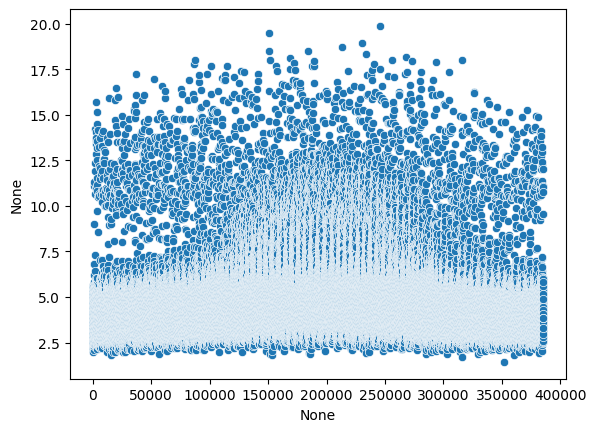

In [24]:
min_values = pmax_clms.min(axis=1)
sb.scatterplot(x=min_values.index, y=min_values)
# not quite as obvious...

Maybe we can look at the sum of the errors between records and the mean average values for each respective xy-point

In [25]:
repeated = pd.DataFrame(np.repeat(xy_pmax_average.drop(columns=['x', 'y']).values, 100, axis=0))
repeated.columns = pmax_clm_names
repeated

,pmax[1],pmax[2],pmax[3],pmax[4],pmax[5],pmax[6],pmax[8],pmax[9],pmax[10],pmax[11],pmax[13],pmax[14]
0,4.673998,4.845091,4.815911,4.765275,9.295822,5.274141,25.497638,97.715352,40.392624,10.077815,8.085784,5.151071
1,4.673998,4.845091,4.815911,4.765275,9.295822,5.274141,25.497638,97.715352,40.392624,10.077815,8.085784,5.151071
2,4.673998,4.845091,4.815911,4.765275,9.295822,5.274141,25.497638,97.715352,40.392624,10.077815,8.085784,5.151071
3,4.673998,4.845091,4.815911,4.765275,9.295822,5.274141,25.497638,97.715352,40.392624,10.077815,8.085784,5.151071
4,4.673998,4.845091,4.815911,4.765275,9.295822,5.274141,25.497638,97.715352,40.392624,10.077815,8.085784,5.151071
...,...,...,...,...,...,...,...,...,...,...,...,...
385495,51.544349,58.428994,66.864854,13.336358,12.306240,5.521397,5.344906,5.212512,5.972605,5.594298,18.613362,8.955890
385496,51.544349,58.428994,66.864854,13.336358,12.306240,5.521397,5.344906,5.212512,5.972605,5.594298,18.613362,8.955890
385497,51.544349,58.428994,66.864854,13.336358,12.306240,5.521397,5.344906,5.212512,5.972605,5.594298,18.613362,8.955890
385498,51.544349,58.428994,66.864854,13.336358,12.306240,5.521397,5.344906,5.212512,5.972605,5.594298,18.613362,8.955890


In [26]:
diff = pmax_clms - repeated
diff

,pmax[1],pmax[2],pmax[3],pmax[4],pmax[5],pmax[6],pmax[8],pmax[9],pmax[10],pmax[11],pmax[13],pmax[14]
0,0.735164,1.239415,-1.004583,0.127753,0.026483,-2.196803,1.083615,1.645912,1.675769,2.360643,-0.630907,1.460806
1,-0.259709,-0.337834,-0.875542,0.784105,0.078092,0.150215,2.299377,-1.652791,-1.702414,2.248396,10.386731,8.651181
2,-0.106807,0.539064,0.087501,-0.969867,-1.795926,0.572092,-2.333988,-3.947954,-0.055557,-0.824565,-0.749116,0.788968
3,0.345061,-0.679493,-1.024239,0.083445,1.126438,-0.116213,1.095260,-8.094914,-2.595850,0.823061,0.364888,1.283838
4,-1.423735,-0.109068,0.307137,-1.738566,3.261984,0.840905,-0.235929,8.394078,1.809399,3.878844,0.636168,-0.667991
...,...,...,...,...,...,...,...,...,...,...,...,...
385495,-1.724974,-2.777554,-3.745249,-1.393359,0.571888,-0.917030,-0.676065,-1.887930,-0.954005,-0.067504,0.840703,-3.113327
385496,-0.527855,-0.344970,-6.893696,-1.781103,-2.576754,-1.445823,8.756903,7.607477,6.127797,9.614265,-1.008727,2.863141
385497,-4.882667,3.411109,6.985235,3.548539,0.797822,0.860381,1.815766,-1.352530,0.614780,-0.251000,2.170161,1.164769
385498,-5.028584,-8.656924,-7.586927,-1.144698,-1.167225,9.085472,11.132801,6.172666,7.242299,8.010758,-4.565096,1.798990


In [27]:
# When we square the values we can see that row 385496 and 385498 clearly go way above the others, aka. outliers

sqrd = diff**2
sqrd

,pmax[1],pmax[2],pmax[3],pmax[4],pmax[5],pmax[6],pmax[8],pmax[9],pmax[10],pmax[11],pmax[13],pmax[14]
0,0.540466,1.536150,1.009187,0.016321,0.000701,4.825944,1.174221,2.709028,2.808202,5.572636,0.398044,2.133955
1,0.067449,0.114132,0.766574,0.614820,0.006098,0.022565,5.287135,2.731717,2.898213,5.055287,107.884172,74.842932
2,0.011408,0.290590,0.007656,0.940643,3.225349,0.327289,5.447499,15.586337,0.003087,0.679907,0.561175,0.622471
3,0.119067,0.461711,1.049066,0.006963,1.268862,0.013506,1.199595,65.527632,6.738435,0.677429,0.133143,1.648241
4,2.027022,0.011896,0.094333,3.022610,10.640538,0.707121,0.055662,70.460551,3.273926,15.045429,0.404709,0.446212
...,...,...,...,...,...,...,...,...,...,...,...,...
385495,2.975534,7.714804,14.026891,1.941448,0.327056,0.840944,0.457064,3.564279,0.910125,0.004557,0.706781,9.692806
385496,0.278630,0.119004,47.523041,3.172326,6.639662,2.090405,76.683357,57.873709,37.549902,92.434087,1.017529,8.197575
385497,23.840439,11.635666,48.793507,12.592129,0.636519,0.740255,3.297005,1.829336,0.377955,0.063001,4.709601,1.356686
385498,25.286657,74.942328,57.561461,1.310334,1.362414,82.545808,123.939249,38.101803,52.450901,64.172248,20.840097,3.236364


In [28]:
sum_of_squares = sqrd.sum(axis=1)
# lets plot this...
sum_of_squares[sum_of_squares > 500]

102        884.694076
462        561.370313
634       1192.462403
651       1054.453651
979        567.386539
             ...     
384863     651.126935
384902     659.393635
385082    2885.901094
385461     530.194418
385498     545.749663
Length: 3129, dtype: float64

In [29]:
display(updated.loc[385082][pmax_clm_names+['x', 'y']])
display(xy_pmax_average[(xy_pmax_average['x']==600) & (xy_pmax_average['y']==575)])

pmax[1]      23.334253
pmax[2]      14.743649
pmax[3]      53.932281
pmax[4]       7.570258
pmax[5]      10.128049
pmax[6]       6.113630
pmax[8]       5.605933
pmax[9]       6.520979
pmax[10]      5.998462
pmax[11]      7.309558
pmax[13]     19.451074
pmax[14]     10.655231
x           600.000000
y           575.000000
Name: 385082, dtype: float64

,x,y,pmax[1],pmax[2],pmax[3],pmax[4],pmax[5],pmax[6],pmax[8],pmax[9],pmax[10],pmax[11],pmax[13],pmax[14]
3850,600.0,575.0,61.077165,50.300009,66.164552,12.790822,13.034845,5.420599,4.934395,4.747463,6.204322,5.718607,21.717369,10.678588


(370000.0, 400000.0)

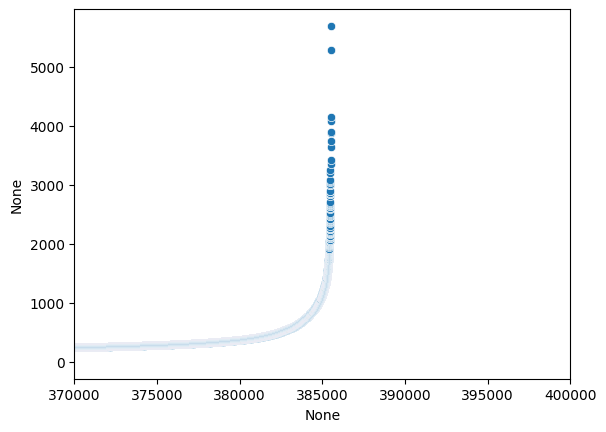

In [30]:
plot = sb.scatterplot(x=pd.Series(np.sort(sum_of_squares)).index, y=pd.Series(np.sort(sum_of_squares)))
plot.set_xlim(370000, 400000)

(384000.0, 386000.0)

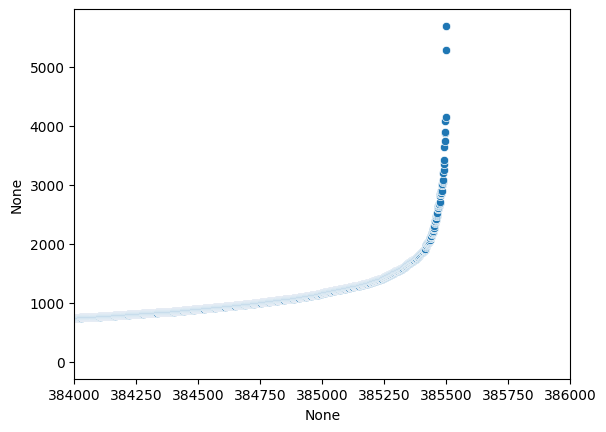

In [31]:
plot = sb.scatterplot(x=pd.Series(np.sort(sum_of_squares)).index, y=pd.Series(np.sort(sum_of_squares)))
plot.set_xlim(384000, 386000)

In [32]:
THRESH_SS = 500
ss_above_thresh = sum_of_squares[sum_of_squares > THRESH_SS]
xy_above_thresh = updated.loc[ss_above_thresh.index.values][['x', 'y']]
averages = xy_above_thresh.reset_index().merge(xy_pmax_average, how='left').set_index('index')
averages

,x,y,pmax[1],pmax[2],pmax[3],pmax[4],pmax[5],pmax[6],pmax[8],pmax[9],pmax[10],pmax[11],pmax[13],pmax[14]
index,,,,,,,,,,,,,,
102,200.0,220.0,4.804105,4.969650,4.887775,5.199585,9.865108,5.619067,28.907010,80.814798,42.582264,9.437253,8.325107,5.141895
462,200.0,235.0,4.873844,4.895229,5.280248,5.092229,12.954250,6.960811,38.531137,87.065412,53.281208,11.023793,9.821878,5.313154
634,200.0,250.0,4.907378,4.703422,5.128050,5.100540,14.410561,7.788375,44.989675,77.865657,55.052655,10.696446,10.836257,5.672952
651,200.0,250.0,4.907378,4.703422,5.128050,5.100540,14.410561,7.788375,44.989675,77.865657,55.052655,10.696446,10.836257,5.672952
979,200.0,275.0,4.762632,4.750279,5.555559,5.380587,17.464920,9.446403,55.964100,64.291993,57.939030,10.542473,10.644871,5.176462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384863,600.0,555.0,70.929621,41.432982,63.635106,12.140482,12.934450,5.403865,5.055407,5.072078,7.071386,6.500266,25.551630,12.503344
384902,600.0,565.0,66.479489,45.618968,64.805739,12.225887,13.201598,5.750048,4.893648,4.736327,6.388801,6.389933,23.411578,11.202914
385082,600.0,575.0,61.077165,50.300009,66.164552,12.790822,13.034845,5.420599,4.934395,4.747463,6.204322,5.718607,21.717369,10.678588


In [33]:
updated.update(averages)
display(updated.loc[102][pmax_clm_names])

pmax[1]      4.804105
pmax[2]      4.969650
pmax[3]      4.887775
pmax[4]      5.199585
pmax[5]      9.865108
pmax[6]      5.619067
pmax[8]     28.907010
pmax[9]     80.814798
pmax[10]    42.582264
pmax[11]     9.437253
pmax[13]     8.325107
pmax[14]     5.141895
Name: 102, dtype: float64

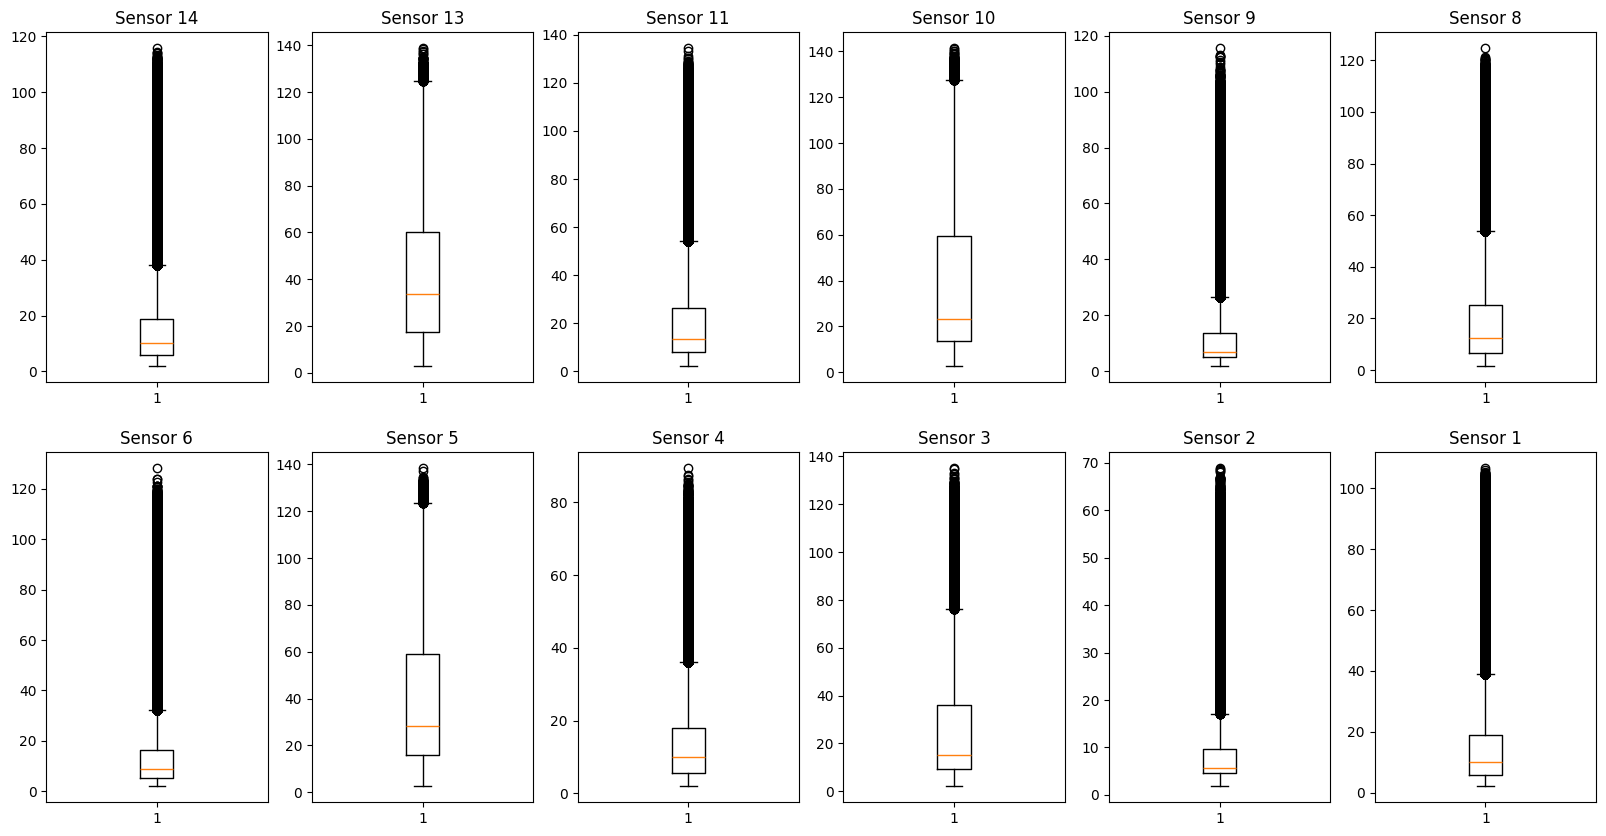

In [34]:
fig, ax = plt.subplots(2, 6, figsize=(20, 10))
idxs = acc_idxs.copy()
for i in range(2):
    for j in range(6):
        idx = idxs.pop()
        ax[i, j].boxplot(updated[f'pmax[{idx}]'])
        ax[i, j].set_title("Sensor " + str(idx))

# Correlations

Text(0.5, 0, 'pmax')

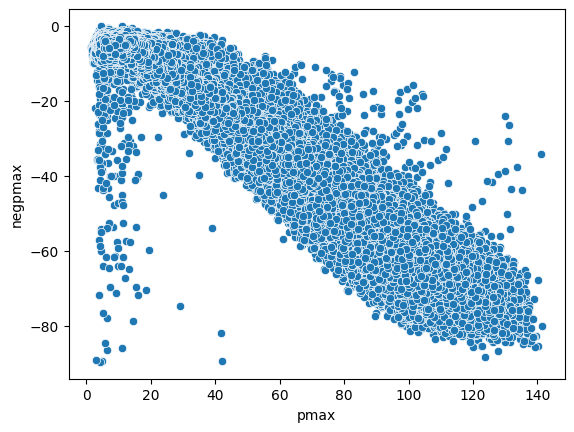

In [35]:
updated_negpmax = updated[negpmax_clm_names]
updated_pmax = updated[pmax_clm_names]
joined_negpmax = pd.concat([updated[clmn] for clmn in updated_negpmax])
joined_pmax = pd.concat([updated[clmn] for clmn in updated_pmax])
scatter = sb.scatterplot(x=joined_pmax, y=joined_negpmax)
scatter.set_ylabel('negpmax')
scatter.set_xlabel('pmax')

In [36]:
sensors_removed = sensors_removed.drop(columns=ph.get_column_names(['rms', 'tmax'], acc_idxs))

In [37]:
subset = sensors_removed.sample(100000, random_state=42)

In [38]:
y_train_valid = subset[['x', 'y']].copy()

X_train_valid = subset.drop(columns=['x', 'y'])

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, shuffle=True, random_state=42, stratify=y_train_valid)

In [40]:
reg = RandomForestRegressor(max_features='sqrt', n_estimators=100, max_depth=40)
reg.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
med = ph.mean_euclid_dist(y_valid, reg.predict(X_valid))
print(med)

4.697436216512975


In [41]:
updated = updated.drop(columns=ph.get_column_names(['rms', 'tmax'], acc_idxs))

In [42]:
updated_subset = updated.sample(100000, random_state=42)

In [43]:
y_train_valid = updated_subset[['x', 'y']].copy()

X_train_valid = updated_subset.drop(columns=['x', 'y'])

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, shuffle=True, random_state=42, stratify=y_train_valid)

In [45]:
reg = RandomForestRegressor(max_features='sqrt', n_estimators=100, max_depth=40)
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=40, max_features='sqrt')

In [46]:
med_updated = ph.mean_euclid_dist(y_valid, reg.predict(X_valid))
print(med_updated)

4.528391473231235


In [47]:
sorted(zip(X_train_valid.columns, reg.feature_importances_), key=lambda x: x[1],reverse=True)

[('pmax[8]', 0.10782140371983084),
 ('pmax[1]', 0.0751867694558355),
 ('pmax[4]', 0.06304416823987351),
 ('pmax[3]', 0.05880686087629883),
 ('pmax[14]', 0.05356659355879159),
 ('negpmax[8]', 0.04917327668168427),
 ('pmax[11]', 0.04800956283887246),
 ('pmax[6]', 0.046116799542350484),
 ('negpmax[10]', 0.04173396077875401),
 ('negpmax[3]', 0.04089183004498268),
 ('negpmax[11]', 0.040154444504912123),
 ('pmax[5]', 0.03965786631210696),
 ('pmax[10]', 0.03907127513877487),
 ('pmax[9]', 0.0334030131485193),
 ('negpmax[13]', 0.027240699730447016),
 ('negpmax[5]', 0.02550601422777052),
 ('pmax[13]', 0.023407822306383528),
 ('area[5]', 0.02089663126563628),
 ('negpmax[1]', 0.019489661165774514),
 ('area[10]', 0.018673280575025795),
 ('negpmax[14]', 0.013595538749832154),
 ('area[3]', 0.013565980032242901),
 ('area[11]', 0.012635761144470776),
 ('negpmax[9]', 0.012374143616655144),
 ('negpmax[4]', 0.011428329376977839),
 ('negpmax[6]', 0.011148226289940506),
 ('pmax[2]', 0.009871699666950942),
 

In [ ]:
y_train_valid = updated[['x', 'y']].copy()

X_train_valid = updated.drop(columns=['x', 'y'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, shuffle=True, random_state=42, stratify=y_train_valid)

In [ ]:
reg = RandomForestRegressor(max_features='sqrt', n_estimators=400, max_depth=40, verbose=1)
reg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  5.8min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 22.5min


RandomForestRegressor(max_depth=40, max_features='sqrt', n_estimators=400,
                      verbose=1)

In [ ]:
y_pred = reg.predict(X_valid)
med_updated = ph.mean_euclid_dist(y_valid, y_pred)
print(med_updated)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   14.3s


4.056602870717484


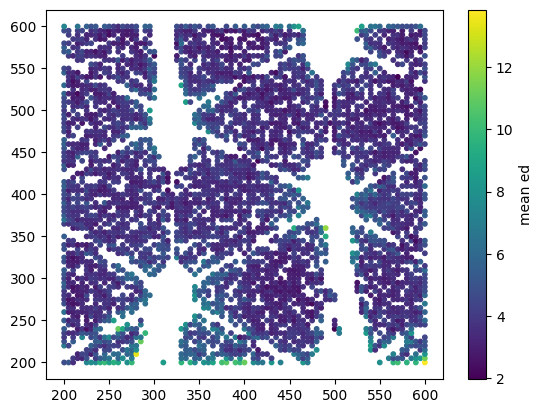

In [ ]:
ph.create_acc_map(y_valid, y_pred)